In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display

from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, recall_score, precision_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_predict

In [2]:
# Sets the Ipython options

InteractiveShell.ast_node_interactivity = "all"

<h6>Design

In [3]:
# Sizes

title_size = 50
tick_size = 30
text_size = 30

In [28]:
# Colors

meta_color = 'black'

<h6>Set up

In [4]:
df = pd.read_csv(r'/mnt/d/Kaggle/Telecom_Churn_Prediction/Cleaned/df_cleaned')

random_seed = 34

Stratification

In [5]:
stratified_shuffle_split = StratifiedShuffleSplit(test_size=0.2, random_state=random_seed)

In [6]:
for train_index, test_index in stratified_shuffle_split\
                                    .split(df.drop(['Churn'], axis = 1), 
                                           df['Churn']):
    
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

Counter(df['Churn'])
Counter(strat_train_set['Churn'])
Counter(strat_test_set['Churn'])

Counter({'No': 5174, 'Yes': 1869})

Counter({'No': 4139, 'Yes': 1495})

Counter({'No': 1035, 'Yes': 374})

Train Test Sets

In [7]:
X_train = strat_train_set.drop(['customerID','Churn'], axis = 1)
X_test = strat_test_set.drop(['customerID','Churn'], axis = 1)

In [8]:
y_train = strat_train_set['Churn'].apply(lambda x : 0 if x == 'No' else 1)
y_test = strat_test_set['Churn'].apply(lambda x : 0 if x == 'No' else 1)

<h6>Pipelines

In [9]:
# One Hot Encode Pipeline

categorical_pipeline = Pipeline([
    ('One_hot_encoder', OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False))
])

# Column Transformer

column_transformer = \
    ColumnTransformer([
        ('Categorical_pipeline', categorical_pipeline, 
                                      make_column_selector(dtype_include=['O']))], 
    remainder='passthrough')

Functions

In [10]:
def plot_confusion_matrix(y_ground_truth, y_predicted, threshold):

    fig, ax = plt.subplots(figsize=(5,5))

    computed_confusion_matrix = \
            confusion_matrix(y_ground_truth, (y_predicted[:,1] >= threshold).astype(int))


    sns.heatmap(pd.DataFrame(computed_confusion_matrix), 
                annot=True, 
                fmt=".0f", 
                square=True,
                ax = ax,
                cbar=False,
                annot_kws={"size": text_size}
    )

    ax.set_ylabel('Actual Class', fontsize=text_size)
    ax.set_xlabel('Predicted Class', fontsize=text_size)
    ax.tick_params(labelsize=tick_size)
    ax.set_title('Thr={:.2f}'.format(threshold), fontsize=title_size-10)
    plt.show();
    
def find_optimal_threshold(y_ground_truth, y_predicted):
    
    fpr, tpr, thresholds = roc_curve(y_ground_truth, y_predicted[:,1])
    
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    return optimal_threshold

def return_recall_precision_f1(y_ground_truth, y_predicted, threshold, model_name='model'):
    
    recall = recall_score(y_ground_truth, (y_predicted[:,1] >= threshold).astype(int))
    precision = precision_score(y_ground_truth, (y_predicted[:,1] >= threshold).astype(int))
    f1 = f1_score(y_ground_truth, (y_predicted[:,1] >= threshold).astype(int))
     
    metrics_df = pd.DataFrame(columns = ['recall', 'precision', 'f1-score'], 
                              data = [[recall, precision, f1]], 
                              index = ['{} scores'.format(model_name)])
    
    
    return metrics_df

<center><h3>Modeling

Scoring

In [11]:
scoring = {'roc_auc': 'roc_auc'}

model_refit = 'roc_auc'

LR

In [12]:
lr_pipe = Pipeline([
    ('Column_transformer', column_transformer),
    ('Over_Sampling', None),
    ('Under_Sampling', None),
    ('Scaler', None),
    ('Dim_Reduction', None),
    ('Logistic_regression', LogisticRegression(random_state=random_seed))
])

In [13]:
lr_pipe_params = [{
    
    # Sampling Params
    
    'Over_Sampling': [None, SMOTE(random_state=random_seed), ADASYN(random_state=34)],
    'Under_Sampling': [None, RandomUnderSampler(random_state=34)],
    
    # Scaling Params
    
    'Scaler' : [None, StandardScaler(), MinMaxScaler(), RobustScaler()], 
    
    # Dimentionality Reduction
    
    #'Dim_Reduction' : [PCA(n_components=2), PCA(n_components=5), PCA(n_components=10)],
    
    # Model Params
    
    'Logistic_regression__max_iter' : [1000]
}]

In [14]:
lr_pipe_gs = GridSearchCV(
                           lr_pipe, 
                           lr_pipe_params, 
                           cv=5, 
                           scoring=scoring,
                           return_train_score=False,
                           refit=model_refit,
                           n_jobs = -1)

lr_pipe_gs.fit(X_train, y_train);

In [15]:
lr_pipe_gs.best_score_ # 0.846
lr_pipe_gs.best_estimator_

0.8462918153732997

Pipeline(steps=[('Column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Categorical_pipeline',
                                                  Pipeline(steps=[('One_hot_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f00a585ad90>)])),
                ('Over_Sampling', None), ('Under_Sampling', None),
                ('Scaler', StandardScaler()), ('Dim_Reduction', None),
                ('Logistic_regression',
                 LogisticRegression(max_iter=1000, random_state=34))])

In [16]:
lr_pred_train = cross_val_predict(lr_pipe_gs.best_estimator_, 
                                  X_train, 
                                  y_train, 
                                  cv=5, 
                                  n_jobs = -1, 
                                  method="predict_proba")

In [17]:
lr_optimal_threshold = find_optimal_threshold(y_train, lr_pred_train)
lr_optimal_threshold

0.2990070310605596

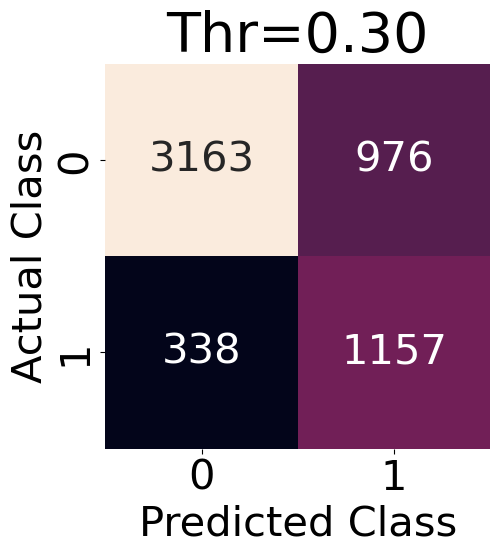

In [18]:
plot_confusion_matrix(y_train, lr_pred_train, lr_optimal_threshold)

In [19]:
return_recall_precision_f1(y_train, lr_pred_train, lr_optimal_threshold, 'lr')

,recall,precision,f1-score
lr scores,0.773913,0.542429,0.637817


Random Forest

In [20]:
rf_pipe = Pipeline([
    ('Column_transformer', column_transformer),
    ('Over_Sampling', None),
    ('Under_Sampling', None),
    ('Random_forest', RandomForestClassifier(random_state=random_seed))
])

In [21]:
rf_pipe_params = [{
    
    # Sampling Params
    
    'Over_Sampling': [None, SMOTE(random_state=random_seed), ADASYN(random_state=34)],
    'Under_Sampling': [None, RandomUnderSampler(random_state=34)]
    
}]

In [22]:
# Grid searches random_forest_pipeline

rf_pipe_gs = GridSearchCV(rf_pipe, 
                          rf_pipe_params, 
                          cv=5, 
                          scoring=scoring,
                          return_train_score=False,
                          refit=model_refit,
                          n_jobs = -1)

rf_pipe_gs.fit(X_train, y_train);

In [23]:
rf_pipe_gs.best_score_ # 0.846
rf_pipe_gs.best_estimator_

0.8245605704708115

Pipeline(steps=[('Column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Categorical_pipeline',
                                                  Pipeline(steps=[('One_hot_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f009e679ac0>)])),
                ('Over_Sampling', None), ('Under_Sampling', None),
                ('Random_forest', RandomForestClassifier(random_state=34))])

In [24]:
rf_pred_train = cross_val_predict(rf_pipe_gs.best_estimator_, 
                                  X_train, 
                                  y_train, 
                                  cv=5, 
                                  n_jobs = -1, 
                                  method="predict_proba")

In [25]:
rf_optimal_threshold = find_optimal_threshold(y_train, rf_pred_train)
rf_optimal_threshold

0.3

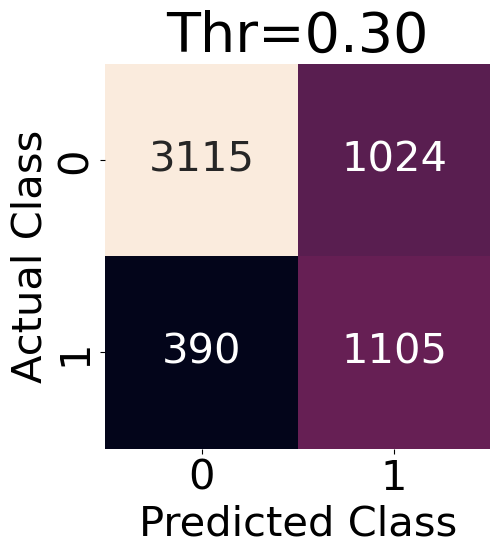

In [26]:
plot_confusion_matrix(y_train, rf_pred_train, rf_optimal_threshold)

In [27]:
return_recall_precision_f1(y_train, rf_pred_train, rf_optimal_threshold, 'rf')

,recall,precision,f1-score
rf scores,0.73913,0.519023,0.609823
